In [1]:
import torch, tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)

In [4]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

In [5]:
# Data
valid_size=0.2
shuffle = True
random_seed = 100
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

num_train = len(trainSet)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

In [6]:
# Model
class Shallow_Net(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*676, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

class Shallow_Net_w_MaxPooling(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net_w_MaxPooling, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*625, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)
    
net_1 = Shallow_Net().to(device)
net_2 = Shallow_Net_w_MaxPooling().to(device)
print(net_1)
print(net_2)

Shallow_Net(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=13520, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)
Shallow_Net_w_MaxPooling(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=12500, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)


In [7]:
def train_fn(epochs, lr, optimizer_name, net ):
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    else : 
        print("Error, please input 'SGD' or Adam.")
    # Train
    epoch_loss = []
    epoch_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_loss_val = 0.0
        running_acc_val = 0.0
        
        for times, data in enumerate(trainLoader):
            net.train()
#             print("Training")
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            running_acc += (labels==predicted).sum().item()
#             if times % 100 == 99 or times+1 == len(trainLoader):
#                 print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/2000))
        with torch.no_grad():
            net.eval()
#             print("Validating.")
            for times_val, data_val in enumerate(valLoader):
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
        #         inputs = inputs.view(inputs.shape[0], -1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Foward + backward + optimize
                outputs_val = net(inputs_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                loss_val = criterion(outputs_val, labels_val)
#                     loss_val.backward()
#                     optimizer.step()

                # Print statistics
                running_loss_val += loss_val.item()
                running_acc_val += (labels_val==predicted_val).sum().item()
            _epoch_val_loss = running_loss_val/len(valLoader)
            _epoch_val_acc = running_acc_val/len(valLoader)
            epoch_val_loss.append(_epoch_val_loss)
            epoch_val_acc.append(_epoch_val_acc)
                
        _epoch_loss = running_loss/len(trainLoader)
        _epoch_acc = running_acc/len(trainLoader)
        epoch_loss.append(_epoch_loss)
        epoch_acc.append(_epoch_acc)
        print("Epoch: {0}, loss: {1:.3f}, acc: {2:.3f}, val_loss: {3:.3f}, val_acc: {4:.3f}".format(epoch+1, _epoch_loss, _epoch_acc, _epoch_val_loss, _epoch_val_acc))
    print('Training Finished.')
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    #             print(class_correct)
    #             print(class_total)

    for i in range(10):
        print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))
    acc = (100*correct / total)
    x = np.linspace(1, epochs, num = epochs)
    plt.plot(x, np.array(epoch_acc)/100, label='acc')
    plt.plot(x, epoch_loss, label='loss')
    plt.plot(x, epoch_val_loss, label='val_loss')
    plt.plot(x, np.array(epoch_val_acc)/100, label='epoch_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc/loss')
    plt.legend(loc="upper right")
    plt.savefig("mnist_cnn_"+optimizer_name+"_ce_shallow_"+str(int(acc))+".png")
    plt.show()

Epoch: 1, loss: 1.706, acc: 48.359, val_loss: 1.588, val_acc: 55.787
Epoch: 2, loss: 1.550, acc: 58.393, val_loss: 1.499, val_acc: 61.505
Epoch: 3, loss: 1.487, acc: 62.396, val_loss: 1.495, val_acc: 61.729
Epoch: 4, loss: 1.482, acc: 62.709, val_loss: 1.489, val_acc: 62.128
Epoch: 5, loss: 1.479, acc: 62.908, val_loss: 1.485, val_acc: 62.340
Epoch: 6, loss: 1.476, acc: 63.071, val_loss: 1.489, val_acc: 62.069
Epoch: 7, loss: 1.475, acc: 63.120, val_loss: 1.485, val_acc: 62.324
Epoch: 8, loss: 1.473, acc: 63.240, val_loss: 1.484, val_acc: 62.319
Epoch: 9, loss: 1.473, acc: 63.287, val_loss: 1.483, val_acc: 62.452
Epoch: 10, loss: 1.471, acc: 63.363, val_loss: 1.486, val_acc: 62.298
Epoch: 11, loss: 1.471, acc: 63.393, val_loss: 1.489, val_acc: 62.043
Epoch: 12, loss: 1.471, acc: 63.385, val_loss: 1.484, val_acc: 62.362
Epoch: 13, loss: 1.470, acc: 63.453, val_loss: 1.485, val_acc: 62.324
Epoch: 14, loss: 1.469, acc: 63.488, val_loss: 1.482, val_acc: 62.527
Epoch: 15, loss: 1.469, acc: 

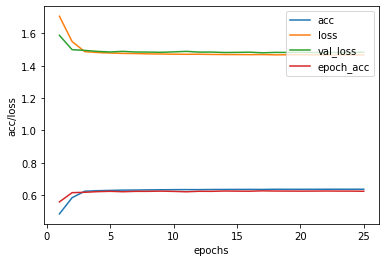

In [15]:
train_fn(25, 0.02, "Adam", net_1)

Epoch: 1, loss: 1.943, acc: 33.001, val_loss: 1.810, val_acc: 41.585
Epoch: 2, loss: 1.797, acc: 42.425, val_loss: 1.790, val_acc: 42.729
Epoch: 3, loss: 1.662, acc: 51.244, val_loss: 1.615, val_acc: 54.064
Epoch: 4, loss: 1.604, acc: 54.929, val_loss: 1.603, val_acc: 54.814
Epoch: 5, loss: 1.592, acc: 55.685, val_loss: 1.600, val_acc: 55.005
Epoch: 6, loss: 1.585, acc: 56.063, val_loss: 1.591, val_acc: 55.606
Epoch: 7, loss: 1.580, acc: 56.421, val_loss: 1.587, val_acc: 55.750
Epoch: 8, loss: 1.577, acc: 56.576, val_loss: 1.588, val_acc: 55.718
Epoch: 9, loss: 1.575, acc: 56.699, val_loss: 1.586, val_acc: 55.835
Epoch: 10, loss: 1.574, acc: 56.807, val_loss: 1.583, val_acc: 56.000
Epoch: 11, loss: 1.572, acc: 56.911, val_loss: 1.582, val_acc: 56.144
Epoch: 12, loss: 1.571, acc: 56.947, val_loss: 1.582, val_acc: 56.080
Epoch: 13, loss: 1.570, acc: 57.032, val_loss: 1.580, val_acc: 56.197
Epoch: 14, loss: 1.568, acc: 57.124, val_loss: 1.580, val_acc: 56.207
Epoch: 15, loss: 1.567, acc: 

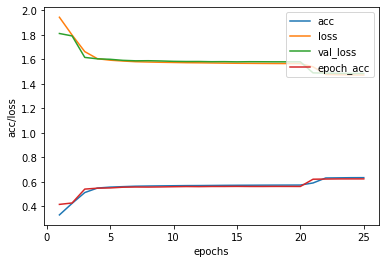

In [8]:
# net_1.apply(weights_init)
train_fn(25, 0.02, "SGD", net_1)

Epoch: 1, loss: 1.614, acc: 54.389, val_loss: 1.586, val_acc: 55.878
Epoch: 2, loss: 1.548, acc: 58.451, val_loss: 1.492, val_acc: 61.878
Epoch: 3, loss: 1.486, acc: 62.415, val_loss: 1.489, val_acc: 62.085
Epoch: 4, loss: 1.481, acc: 62.731, val_loss: 1.489, val_acc: 62.074
Epoch: 5, loss: 1.479, acc: 62.861, val_loss: 1.485, val_acc: 62.319
Epoch: 6, loss: 1.477, acc: 62.984, val_loss: 1.482, val_acc: 62.516
Epoch: 7, loss: 1.477, acc: 63.013, val_loss: 1.483, val_acc: 62.399
Epoch: 8, loss: 1.475, acc: 63.096, val_loss: 1.481, val_acc: 62.585
Epoch: 9, loss: 1.474, acc: 63.177, val_loss: 1.483, val_acc: 62.447
Epoch: 10, loss: 1.473, acc: 63.231, val_loss: 1.480, val_acc: 62.622
Epoch: 11, loss: 1.472, acc: 63.280, val_loss: 1.481, val_acc: 62.585
Epoch: 12, loss: 1.472, acc: 63.336, val_loss: 1.484, val_acc: 62.383
Epoch: 13, loss: 1.472, acc: 63.333, val_loss: 1.480, val_acc: 62.670
Epoch: 14, loss: 1.471, acc: 63.384, val_loss: 1.481, val_acc: 62.559
Epoch: 15, loss: 1.470, acc: 

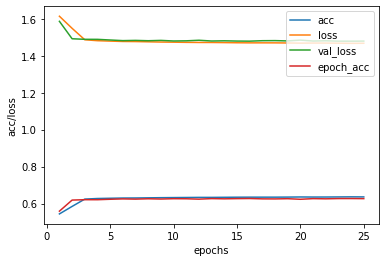

In [8]:
train_fn(25, 0.02, "Adam", net_2)

Epoch: 1, loss: 1.668, acc: 50.983, val_loss: 1.610, val_acc: 54.420
Epoch: 2, loss: 1.572, acc: 57.029, val_loss: 1.509, val_acc: 61.005
Epoch: 3, loss: 1.498, acc: 61.836, val_loss: 1.495, val_acc: 61.798
Epoch: 4, loss: 1.490, acc: 62.285, val_loss: 1.498, val_acc: 61.463
Epoch: 5, loss: 1.486, acc: 62.492, val_loss: 1.488, val_acc: 62.202
Epoch: 6, loss: 1.483, acc: 62.701, val_loss: 1.490, val_acc: 62.043
Epoch: 7, loss: 1.481, acc: 62.797, val_loss: 1.485, val_acc: 62.287
Epoch: 8, loss: 1.479, acc: 62.900, val_loss: 1.489, val_acc: 62.117
Epoch: 9, loss: 1.478, acc: 62.971, val_loss: 1.491, val_acc: 61.952
Epoch: 10, loss: 1.477, acc: 63.040, val_loss: 1.484, val_acc: 62.415
Epoch: 11, loss: 1.475, acc: 63.153, val_loss: 1.483, val_acc: 62.479
Epoch: 12, loss: 1.473, acc: 63.256, val_loss: 1.484, val_acc: 62.452
Epoch: 13, loss: 1.474, acc: 63.197, val_loss: 1.483, val_acc: 62.452
Epoch: 14, loss: 1.473, acc: 63.271, val_loss: 1.483, val_acc: 62.457
Epoch: 15, loss: 1.472, acc: 

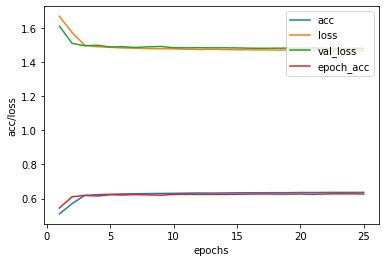

In [8]:
# net_2.apply(weights_init)
train_fn(25, 0.02, "SGD", net_2)